In [1]:
import matplotlib.pyplot as plt
import numpy as np
import bemcs

# Construct triangle and compute u,σ

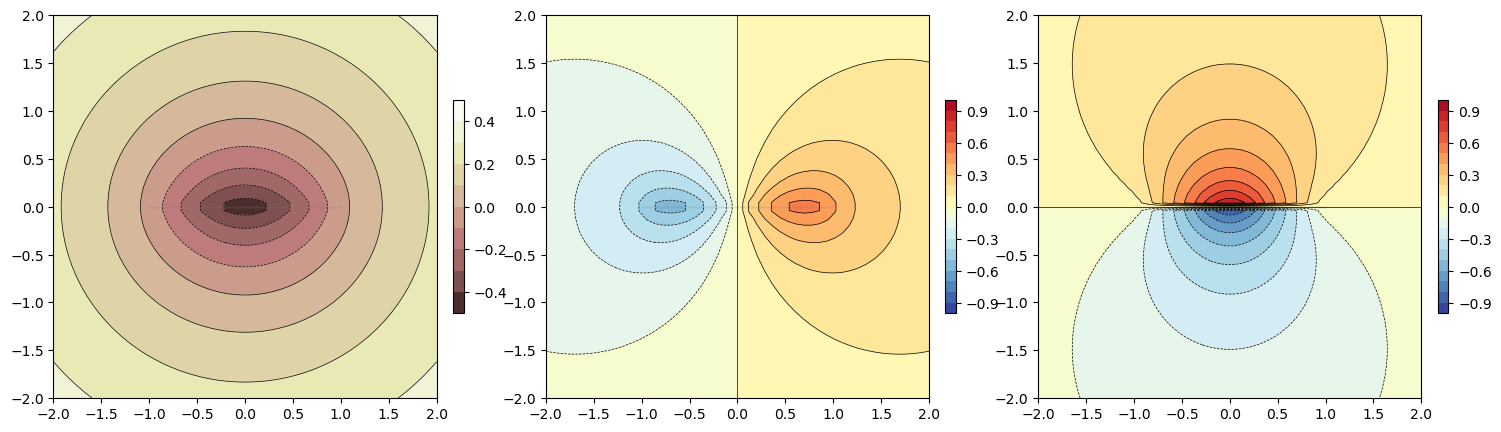

In [64]:
def triangle_area(vertices):
    """
    Compute the area of a triangle given its three vertices.

    Parameters:
    vertices (np.array): A (3, 2) array containing the coordinates of the triangle's vertices.

    Returns:
    float: The area of the triangle.
    """
    x1, y1 = vertices[0]
    x2, y2 = vertices[1]
    x3, y3 = vertices[2]

    # Using the determinant formula to compute the area
    area = 0.5 * abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))

    return area


# Reference triangle geometry
triangle = np.array([[-1, -0.0], [1.0, -0.0], [-0.0, -0.0000001]])
area = triangle_area(triangle)

# Observation coordinates
nx = 50
ny = 50
x_obs, y_obs = np.meshgrid(np.linspace(-2, 2, nx), np.linspace(-2, 2, ny))
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Elastic parameters
mu = 1.0
# Applied force
fval = 2.0

u, sx, sy = bemcs.displacements_stresses_triangle_force_antiplane_farfield(
    triangle, x_obs, y_obs, fval, mu
)

maxval = 0.5  # np.max(np.abs(sx))
levels = np.linspace(-maxval, maxval, 11)
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    u.reshape(ny, nx),
    cmap="pink",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.contour(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    u.reshape(ny, nx),
    levels=levels,
    colors="k",
    linewidths=0.5,
)
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

maxval = 1.0
levels = np.linspace(-maxval, maxval, 21)
plt.subplot(1, 3, 2)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sx.reshape(ny, nx),
    cmap="RdYlBu_r",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.contour(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sx.reshape(ny, nx),
    levels=levels,
    colors="k",
    linewidths=0.5,
)
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(1, 3, 3)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sy.reshape(ny, nx),
    cmap="RdYlBu_r",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.contour(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sy.reshape(ny, nx),
    levels=levels,
    colors="k",
    linewidths=0.5,
)
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

# sy + triangle

# Plot results from near-field and far-field

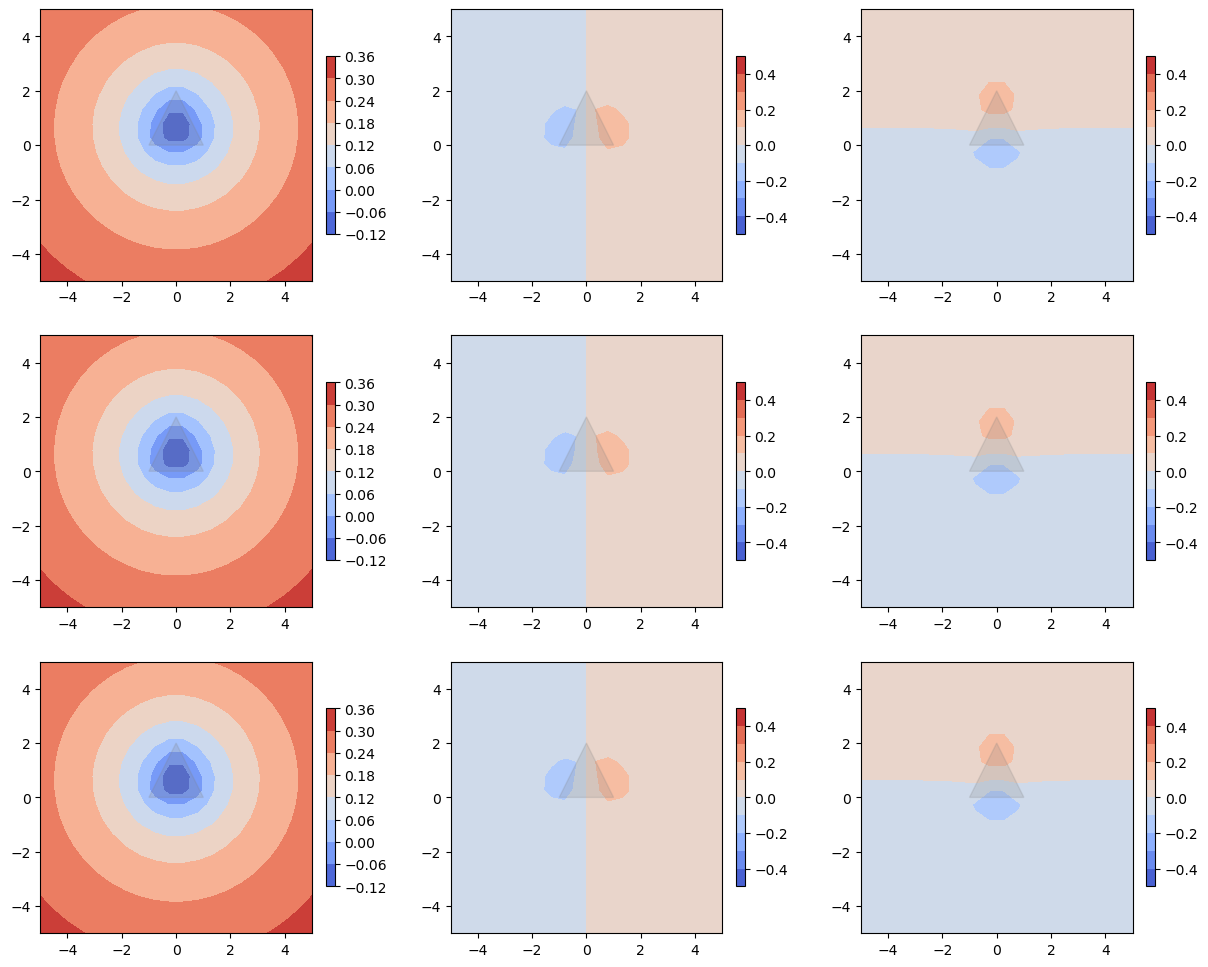

In [ ]:
u_near, sx_near, sy_near = (
    bemcs.displacements_stresses_triangle_force_antiplane_nearfield(
        triangle, x_obs, y_obs, fval, mu
    )
)
u_far, sx_far, sy_far = bemcs.displacements_stresses_triangle_force_antiplane_farfield(
    triangle, x_obs, y_obs, fval, mu
)
# Plot results

plt.figure(figsize=(15, 12))
plt.subplot(3, 3, 1)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    u_near.reshape(ny, nx),
    cmap="coolwarm",
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 3, 2)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sx_near.reshape(ny, nx),
    cmap="coolwarm",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.clim([-0.5, 0.5])
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 3, 3)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sy_near.reshape(ny, nx),
    cmap="coolwarm",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.clim([-0.5, 0.5])
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 3, 4)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    u_far.reshape(ny, nx),
    cmap="coolwarm",
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 3, 5)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sx_far.reshape(ny, nx),
    cmap="coolwarm",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.clim([-0.5, 0.5])
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 3, 6)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sy_far.reshape(ny, nx),
    cmap="coolwarm",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.clim([-0.5, 0.5])
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 3, 7)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    u.reshape(ny, nx),
    cmap="coolwarm",
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 3, 8)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sx.reshape(ny, nx),
    cmap="coolwarm",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.clim([-0.5, 0.5])
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 3, 9)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sy.reshape(ny, nx),
    cmap="coolwarm",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.clim([-0.5, 0.5])
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()